goal : predicts if pair's 1st digit <= to the second (=0) or if pair's 1st digit > to the second (=1)

Ideas of architectures to test :
- Simple MLP (fully connected)
- LetNet5
- AlexNet
- VGGNet19
- Residual Net
- Use cross entropy
- Use dropout

General framework to test :
- Network is trained to predict directly lesser or greater
- Network is trained to predict number, then we do the difference

In this notebook we explore the first architecture only

# Dataset

In [1]:
import torch
from torch import Tensor
from torch import nn
from torch.utils.data import Dataset, DataLoader
import dlc_practical_prologue as prologue

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class PairsDataset(Dataset):
    
    def __init__(self, train_input, train_target, augment_data=False):
        if augment_data :
            # Create the inversed pairs (data augmentation)
            train_input_rev = train_input[:,[1,0],:,:]
            train_target_rev = train_target[:,[1,0]]
            self.train_input = torch.cat((train_input,train_input_rev))
            self.train_target = torch.cat((train_target,train_target_rev))
        else :
            self.train_input = train_input
            self.train_target = train_target

    def __len__(self):
        return len(self.train_input)

    def __getitem__(self, idx):
        return {'pair': self.train_input[idx], 'target': self.train_target[idx]}

In [3]:
def hot_encode(data):
    """ 2-class hot encoding of target """
    col_view = data.view(-1,1)
    return torch.cat((col_view == 0, col_view == 1), dim=1).float()

In [4]:
# Train samples amount
N = 1000
# Load data
train_input, train_target, _ , test_input, test_target, _ = prologue.generate_pair_sets(N)
# Hot encoding
train_target = hot_encode(train_target)
test_target = hot_encode(test_target)
# Create dataset (for random mini batch sampling)
pairsDataset = PairsDataset(train_input, train_target, augment_data=True)

# Models

In [5]:
class MLP(nn.Module):
    
    """ A multilayer perceptron (i.e fully connected layers only) of L hidden 
    layers of with h hidden neurons per layer """
    
    def __init__(self, L, h):
        super(MLP, self).__init__()
        # (N, 392 (=2*14*14)) -> (N, h)
        self.in_layer = nn.Linear(392, h)
        # (N, h) -> (N, h) -> ... -> (N, h)
        hidden_layers = []
        for l in range(L):
            hidden_layers.append(nn.ReLU())
            hidden_layers.append(nn.Linear(h,h))
        hidden_layers.append(nn.ReLU())
        self.hidden_layers = nn.Sequential(*hidden_layers)
        # (N, h) -> (N, 2)
        self.out_layer = nn.Linear(h, 2)
        
    def forward(self, x):
        # Flatten to vector before linear layers
        x = x.view(x.size(0), -1)
        # MLP net
        x = self.in_layer(x)
        x = self.hidden_layers(x)
        x = self.out_layer(x)
        return x

    
class LeNet5Like(nn.Module):
    
    """ Modified LeNet5 (adapted to have 14*14 inputs & ouptut size 2) """
    
    def __init__(self, dropout=False):
        super(LeNet5Like, self).__init__()
        self.features = nn.Sequential(
              # (N, 2, 14, 14) -> (N, 6, 10, 10)
              nn.Conv2d(2, 6, kernel_size=5),
              nn.ReLU(),
              # (N, 6, 10, 10) -> (N, 6, 5, 5)
              nn.MaxPool2d(kernel_size=2, stride=2),
              # (N, 6, 5, 5) -> (N, 16, 1, 1)
              nn.Conv2d(6, 16, kernel_size=5),
              nn.ReLU()
          )  
        if dropout :
            self.classifier = nn.Sequential(
                  # (N, 16) -> (N, 8)
                  nn.Linear(16, 8),
                  nn.ReLU(),
                  nn.Dropout(0.1),
                  # (N, 8) -> (N, 4)
                  nn.Linear(8, 4),
                  nn.ReLU(),
                  nn.Dropout(0.1),
                  # (N, 4) -> (N, 2)
                  nn.Linear(4, 2)
              )
        else :
            self.classifier = nn.Sequential(
                  # (N, 16) -> (N, 8)
                  nn.Linear(16, 8),
                  nn.ReLU(),
                  # (N, 8) -> (N, 4)
                  nn.Linear(8, 4),
                  nn.ReLU(),
                  # (N, 4) -> (N, 2)
                  nn.Linear(4, 2),
                  nn.ReLU()
              )
        
    def forward(self, x):
        # Feature block
        x = self.features(x)
        # Flatten to vector before linear layers
        x = x.view(x.size(0), -1)
        # Classifier block
        x = self.classifier(x)
        return x
    
    
class VGGNetLike(nn.Module):
    
    """ Inspired from VGGNet, adapted to have 14*14 inputs & ouptut size 2) """
    
    def __init__(self, dropout):
        super(VGGNetLike, self).__init__()
        layers = []
        # We start from 14*14 pictures padded to 16*16 and divide the 
        # dimension by two while multiplying the channel count by two 
        # at each block
        layers.append(nn.ConstantPad2d(1, 0))
        for l in range(4):
            # We go to 64 channels and multiply by 2 the number of
            # channel at each block (like in original VGGNet) 
            channels_count = 2**(6+l)
            prev_channels_count = 2 if (l == 0) else 2**(6+(l-1))
            print((prev_channels_count, channels_count))
            layers.append(nn.Conv2d(prev_channels_count, channels_count, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            #layers.append(nn.Conv2d(channels_count, channels_count, kernel_size=3, padding=1))
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))   
        self.features = nn.Sequential(*layers)
        # Classifier with fully connected layers
        if dropout :
            self.classifier = nn.Sequential(
                  # (N, 512) -> (N, 128)
                  nn.Linear(512, 128),
                  nn.ReLU(),
                  nn.Dropout(0.5),
                  # (N, 128) -> (N, 64)
                  nn.Linear(128, 64),
                  nn.ReLU(),
                  nn.Dropout(0.5),
                  # (N, 64) -> (N, 2)
                  nn.Linear(64, 2)
              )
        else :
            self.classifier = nn.Sequential(
                  # (N, 512) -> (N, 128)
                  nn.Linear(512, 128),
                  nn.ReLU(),
                  # (N, 128) -> (N, 64)
                  nn.Linear(128, 64),
                  nn.ReLU(),
                  # (N, 64) -> (N, 2)
                  nn.Linear(64, 2)
              )
        
    def forward(self, x):
        # Feature block
        x = self.features(x)
        # Flatten to vector before linear layers
        x = x.view(x.size(0), -1)
        # Classifier block
        x = self.classifier(x)
        return x

# Train & Test

In [6]:
def compute_errors(output, target):
    """ Computes error percentage given output and target"""
    errors_amount = (output.argmax(dim=1) != target.argmax(dim=1)).sum().item()
    return (errors_amount / output.shape[0]) * 100

In [7]:
def train(model, train_input, train_target, test_input, test_target) :
    
    lr = 1e-3
    batch_size = 100
    epochs = 200
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    pairsDataset = PairsDataset(train_input, train_target)
    dataloader = DataLoader(pairsDataset, batch_size=batch_size, shuffle=False, 
                            num_workers=0)
    
    criterion = nn.MSELoss()
    
    train_errors = []
    test_errors = []
    
    for e in range(epochs):
        
        print('.', end='')
        for i_batch, batch in enumerate(dataloader):
            inputPairs = batch['pair']
            target = batch['target']
            # Forward pass
            output = model(inputPairs)
            # Compute loss
            loss = criterion(output, target)
            # Backprop & update parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        with torch.no_grad():
            # Compute train error
            output_train = model(train_input)
            train_errors.append(compute_errors(output_train, train_target))
            # Compute test error
            output_test = model(test_input)
            test_errors.append(compute_errors(output_test, test_target))
                
    return train_errors, test_errors

In [8]:
def plot_errors(train_errors, test_errors, title):
    plt.title(title)
    plt.xlabel('epoch')
    plt.ylabel('error %')
    plt.plot(train_errors, label='train error %')
    plt.plot(test_errors, label='test error %')
    plt.ylim(0, 60)
    plt.legend()
    plt.grid()
    plt.show()

........................................................................................................................................................................................................

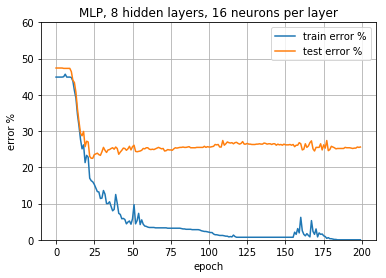

........................................................................................................................................................................................................

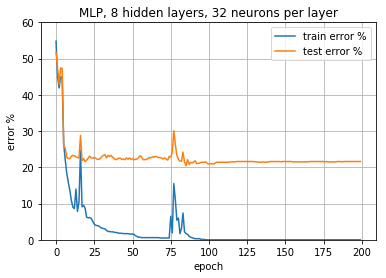

........................................................................................................................................................................................................

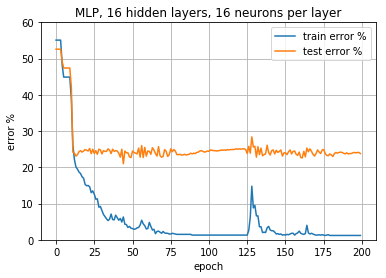

........................................................................................................................................................................................................

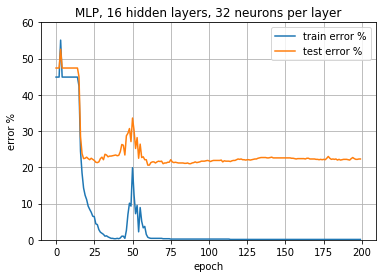

........................................................................................................................................................................................................

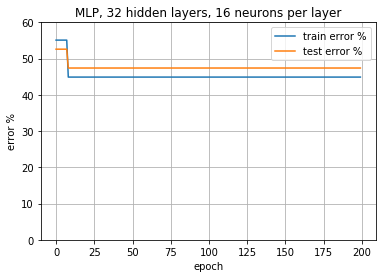

........................................................................................................................................................................................................

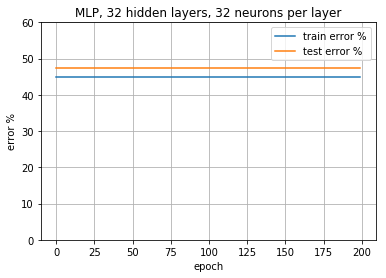

In [9]:
# MLP Models
for L in [8, 16, 32] :
    for h in [16, 32] :
        model = MLP(L, h)
        train_errors, test_errors = train(model, train_input, train_target, test_input, test_target)
        plot_errors(train_errors, test_errors, 'MLP, {} hidden layers, {} neurons per layer'.format(L,h))
        del model

........................................................................................................................................................................................................

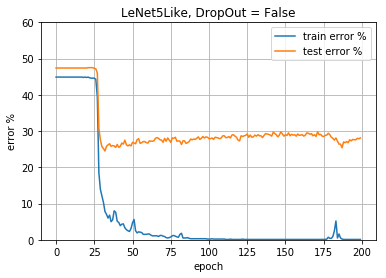

........................................................................................................................................................................................................

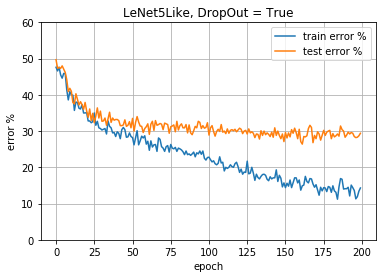

In [10]:
# LeNet5 Model
for dropout in [False, True] :
    model = LeNet5Like(dropout=dropout)
    train_errors, test_errors = train(model, train_input, train_target, test_input, test_target)
    plot_errors(train_errors, test_errors, 'LeNet5Like, DropOut = {}'.format(dropout))
    del model

(2, 64)
(64, 128)
(128, 256)
(256, 512)
........................................................................................................................................................................................................

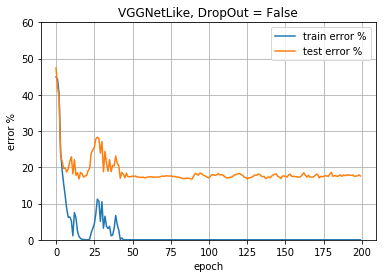

(2, 64)
(64, 128)
(128, 256)
(256, 512)
........................................................................................................................................................................................................

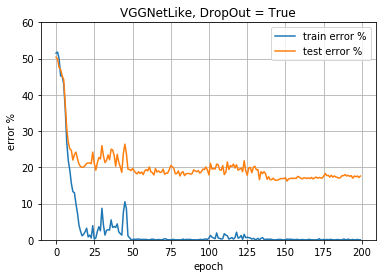

In [11]:
for dropout in [False, True] :
    model = VGGNetLike(dropout=dropout)
    train_errors, test_errors = train(model, train_input, train_target, test_input, test_target)
    plot_errors(train_errors, test_errors, 'VGGNetLike, DropOut = {}'.format(dropout))
    del model